In [0]:
import os
import json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0-rc3


In [2]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin= _URL,
                                   fname = "flower_photos.tgz",
                                   extract = True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 5s 0us/step


In [3]:
base_dir

'/root/.keras/datasets/flower_photos'

ImageDataGenerator digunakan untuk mangubah skala gambar.

Membuat train_generator dan validation_generator


In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.2
)

In [5]:
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size = (224,224),
    batch_size = 64,
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size = (224,224),
    batch_size = 64,
    subset = 'validation'
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [6]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 5))

In [7]:
print(train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [8]:
!cat labels.txt

daisy
dandelion
roses
sunflowers
tulips

# **Create base model from MobileNet V2**

In [11]:
IMG_SHAPE = (224,224,3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet'
)

9412608/9406464 [==============================] - 0s 0us/step


# **Feature Extraction**

In [0]:
base_model.trainable = False

Compile the model



In [0]:
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.Conv2D(32,3, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(5, activation='softmax')
])

In [0]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


# Train the model

In [18]:
history = model.fit(train_generator,
                    steps_per_epoch = len(train_generator),
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps = len(validation_generator))

Epoch 1/10
46/46 [==============================] - 128s 3s/step - loss: 1.2036 - accuracy: 0.5495 - val_loss: 0.5949 - val_accuracy: 0.7921
Epoch 2/10
46/46 [==============================] - 124s 3s/step - loss: 0.4108 - accuracy: 0.8493 - val_loss: 0.4188 - val_accuracy: 0.8440
Epoch 3/10
46/46 [==============================] - 124s 3s/step - loss: 0.2421 - accuracy: 0.9166 - val_loss: 0.4491 - val_accuracy: 0.8523
Epoch 4/10
46/46 [==============================] - 125s 3s/step - loss: 0.1599 - accuracy: 0.9473 - val_loss: 0.4648 - val_accuracy: 0.8509
Epoch 5/10
46/46 [==============================] - 125s 3s/step - loss: 0.1187 - accuracy: 0.9636 - val_loss: 0.4883 - val_accuracy: 0.8700
Epoch 6/10
46/46 [==============================] - 123s 3s/step - loss: 0.0907 - accuracy: 0.9748 - val_loss: 0.4085 - val_accuracy: 0.8824
Epoch 7/10
46/46 [==============================] - 123s 3s/step - loss: 0.0618 - accuracy: 0.9860 - val_loss: 0.5423 - val_accuracy: 0.8618
Epoch 8/10
46

# **Learning Curves**

AttributeError: ignored

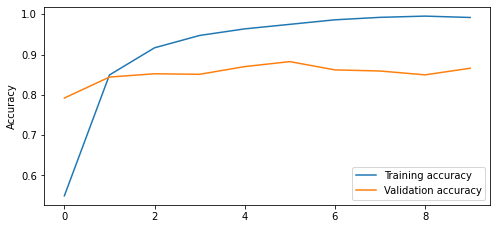

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tunning a pre-trained model

un-freeze the top layers of the model

In [0]:
base_model.trainable = True

In [22]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


# Compile The model

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,231,429
Non-trainable params: 395,392
_________________________________________________________________


In [25]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


# Train the model

In [28]:
history = model.fit(train_generator,
                    steps_per_epoch= len(train_generator),
                    epochs = 5,
                    validation_data = validation_generator,
                    validation_steps = len(validation_generator))

Epoch 1/5
46/46 [==============================] - 208s 5s/step - loss: 0.4653 - accuracy: 0.8465 - val_loss: 0.6041 - val_accuracy: 0.8646
Epoch 2/5
46/46 [==============================] - 205s 4s/step - loss: 0.2598 - accuracy: 0.9102 - val_loss: 0.5286 - val_accuracy: 0.8700
Epoch 3/5
46/46 [==============================] - 208s 5s/step - loss: 0.1759 - accuracy: 0.9391 - val_loss: 0.5399 - val_accuracy: 0.8741
Epoch 4/5
46/46 [==============================] - 205s 4s/step - loss: 0.1271 - accuracy: 0.9653 - val_loss: 0.5022 - val_accuracy: 0.8755
Epoch 5/5
46/46 [==============================] - 206s 4s/step - loss: 0.1027 - accuracy: 0.9721 - val_loss: 0.4881 - val_accuracy: 0.8824


# Convert to TFLite

In [29]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


# Download TF model

In [0]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

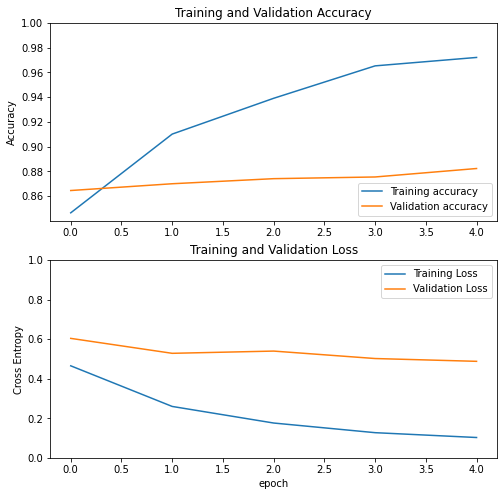

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()